## SHAP (SHAPley Additive exPlanations)
* xAI (eXplaionable AI) : 설명 가능한 인공지능

## 라이브러리 준비

In [2]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 윈도우의 '맑은 고딕' 폰트 설정
plt.rc('font', family='Malgun Gothic')
# 마이너스 기호(-)가 깨지는 현상 방지
plt.rcParams['axes.unicode_minus'] = False
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_california_housing

c:\DS-LOG\KIMDH\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 데이터 확인

In [3]:
housing = fetch_california_housing()
housing

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]], shape=(20640, 8)),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894], shape=(20640,)),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': 

In [4]:
# 데이터프레임화
X = pd.DataFrame(housing.data, columns = housing.feature_names)
Y = housing.target

# 데이터셋 분할
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

# 데이터 정보 확인
print("="*50)
print(f'[학습 데이터 상위 5개]')
print(x_train.head())
print("="*50)
print('\n'f'[학습 데이터 정보]')
print(x_train.info())
print("="*50)

[학습 데이터 상위 5개]
       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
14196  3.2596      33.0  5.017657   1.006421      2300.0  3.691814     32.71   
8267   3.8125      49.0  4.473545   1.041005      1314.0  1.738095     33.77   
17445  4.1563       4.0  5.645833   0.985119       915.0  2.723214     34.66   
14265  1.9425      36.0  4.002817   1.033803      1418.0  3.994366     32.69   
2271   3.5542      43.0  6.268421   1.134211       874.0  2.300000     36.78   

       Longitude  
14196    -117.03  
8267     -118.16  
17445    -120.48  
14265    -117.11  
2271     -119.80  

[학습 데이터 정보]
<class 'pandas.DataFrame'>
Index: 16512 entries, 14196 to 15795
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      16512 non-null  float64
 1   HouseAge    16512 non-null  float64
 2   AveRooms    16512 non-null  float64
 3   AveBedrms   16512 non-null  float64
 4   Population  16512 non-null  fl

### 캘리포니아 데이터셋 피처

| 변수명 | 의미 |
| :--- | :--- |
| **MedInc** | 중위 소득 |
| **HouseAge** | 건물 연령 |
| **AveRooms** | 평균 방 개수 |
| **AveBedrms** | 평균 침실 수 |
| **Population** | 인구 수 |
| **AveOccup** | 평균 가구원 수 |
| **Latitude** | 위도 |
| **Longitude** | 경도 |

### 모델 학습

In [5]:
# 1. 모델 정의 및 훈련 (랜덤포레스트)
model = RandomForestRegressor(n_estimators = 100, random_state = 42, n_jobs = -1)
model.fit(x_train, y_train)

# 2. SHAP 시각화 준비
shap.initjs()

# 3. SHAP 엔진 생성 및 값 계산
# 속도 향상을 위해 전체 데이터가 아닌 테스트 데이터 중 100개 데이터만 한다
x_test_sample = x_test.sample(n = 100, random_state = 42)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test_sample)

# 4. 결과 확인
print(f'기본 기대값 : {explainer.expected_value[0]:.4f}') # Base가 되는 값
print(f'SHAP : {shap_values.shape}')

기본 기대값 : 2.0731
SHAP : (100, 8)


* SHAP는 각 피처가 결과에 미치는 영향을 계산하기 위해 수 많은 조합을 시뮬레이션 한다.
* 테스트 데이터 4,128개에 100개의 나무를 계산하므로 시간이 걸림
* 속도를 향상 하기 위해서는 테스트 데이터의 전체가 아닌 테스트 데이터의 샘플 데이터를 뽑아서 계산하는 것이 효율적이다. (예 : X_test[:100])

### 시각화

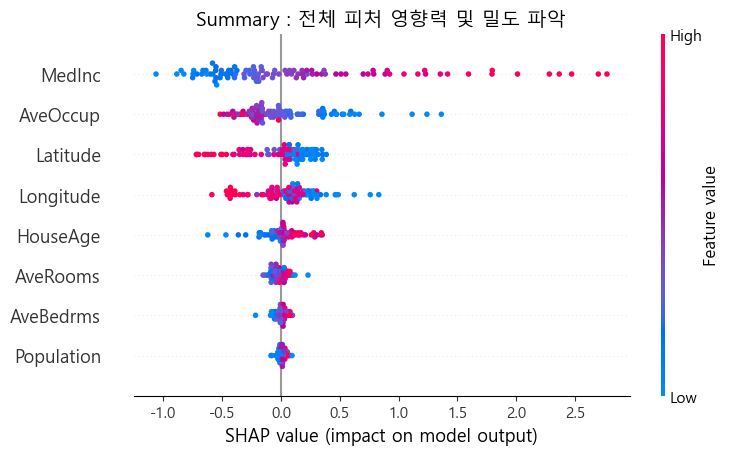

In [6]:
# 1. Summary, Beeswarm
plt.figure(figsize = (10,6))
shap.plots.beeswarm(explainer(x_test_sample), show = False)
plt.title('Summary : 전체 피처 영향력 및 밀도 파악', fontsize = 14)
plt.show()

## 그래프 해석
* 1. feature 순위 : MedInc ~ Population 순으로 중요도를 나타냄
* 2. SHAP value : 0.0을 기준으로 우측이면 가격 상승, 좌측이면 가격 하락 요인
* 3. Feature value : 빨간색은 높은 값, 파란색은 낮은 값
* 4. 두께 : 점들이 위 아래로 뭉쳐 있는 곳은 그 쪽 데이터가 많다는 것을 알 수 있음
## 피쳐별 해석
* 1. MedInc(중위 소득) : 중위소득이 높을 수록 집값을 높게 예측한다. 
* 2. AveOccup(평균 가구원 수) : 평균 가구원 수가 적을 수록 집 값이 높게 예측한다.
* 3. Latitude, Longitude(위, 경도) : 위 경도가 특정 지역에서 높게 예측한다.
* 4. HouseAge(건물 연령) : 건물 연령이 많을 수록 높계 예측한다.
* 5. AveRooms, AveDedrms(평균 방, 침실 수) : 유의미한 차이를 보이지 않는다.
* 6. Population(인구 수) : 평균 방, 침실 수 보다도 유의미한 차이를 보이지 않는다.


<Figure size 1000x600 with 0 Axes>

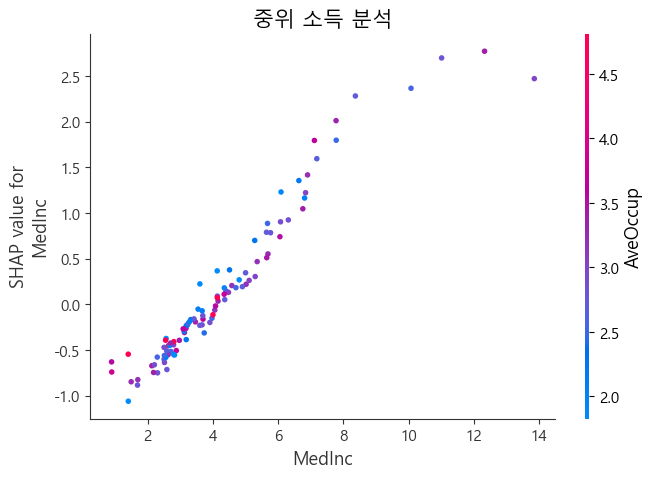

In [7]:
# 2-1 Dependence
plt.figure(figsize = (10,6))
shap.dependence_plot('MedInc', explainer.shap_values(x_test_sample), x_test_sample, show = False)
plt.title('중위 소득 분석', fontsize = 15)
plt.show()

## 중위 소득과 가구 규모 분석

| 구간 | 분석 결과(Observation) | 시사점 (Insight) | 제언 (Actionable Insight) |
| :--- | :--- | :--- | :--- |
| **전체 추세** | 우상향 직선 |집값 예측의 80% 이상은 '동네 소득'이 결정함. 소득과 집값은 정비례|**마케팅 시 소득 수준을 최우선 타겟팅 지표로 설정해야 함**|
| **주력 구간 (2.0 ~ 6.0)** | 데이터 밀집 및 점들의 수직 분산 |중산층 구간에서는 소득 외에 '가족 형태(색깔)'가 가격에 민감하게 작용함|**이 구간에서는 집의 크기나 방 개수(가족용)가 가격 결정의 '조커'임**|
| **파란점 (2.0 ~ 3.5명)** | 빨간 점보다 상대적으로 상단 위치 |**동일 소득일 때, 소규모 가구(파란 점) 지역의 가치 기여도가 더 높음**|**1~2인 가구 중심의 세련된 도심지나 은퇴 부부촌이 높은 프리미엄을 가짐**|
| **빨간점 (4.0 이상)** | 상대적으로 하단 위치 |가구원 수가 너무 많으면 밀집도가 높아 주거 쾌적성이 떨어지는 것으로 모델이 판단|**다인 가구 밀집 지역은 소득이 높더라도 주거 가치 상승에 제약이 있음**|
| **고소득 구간(8.0 이상)** | 점들의 분산이 줄어듦 |일정 수준 이상의 부촌은 가족 수와 상관없이 소득 그 자체가 압도적인 가치를 지님|**초고가 주택 시장은 가구 형태보다 '자산 규모' 그 자체가 유일한 척도임**|


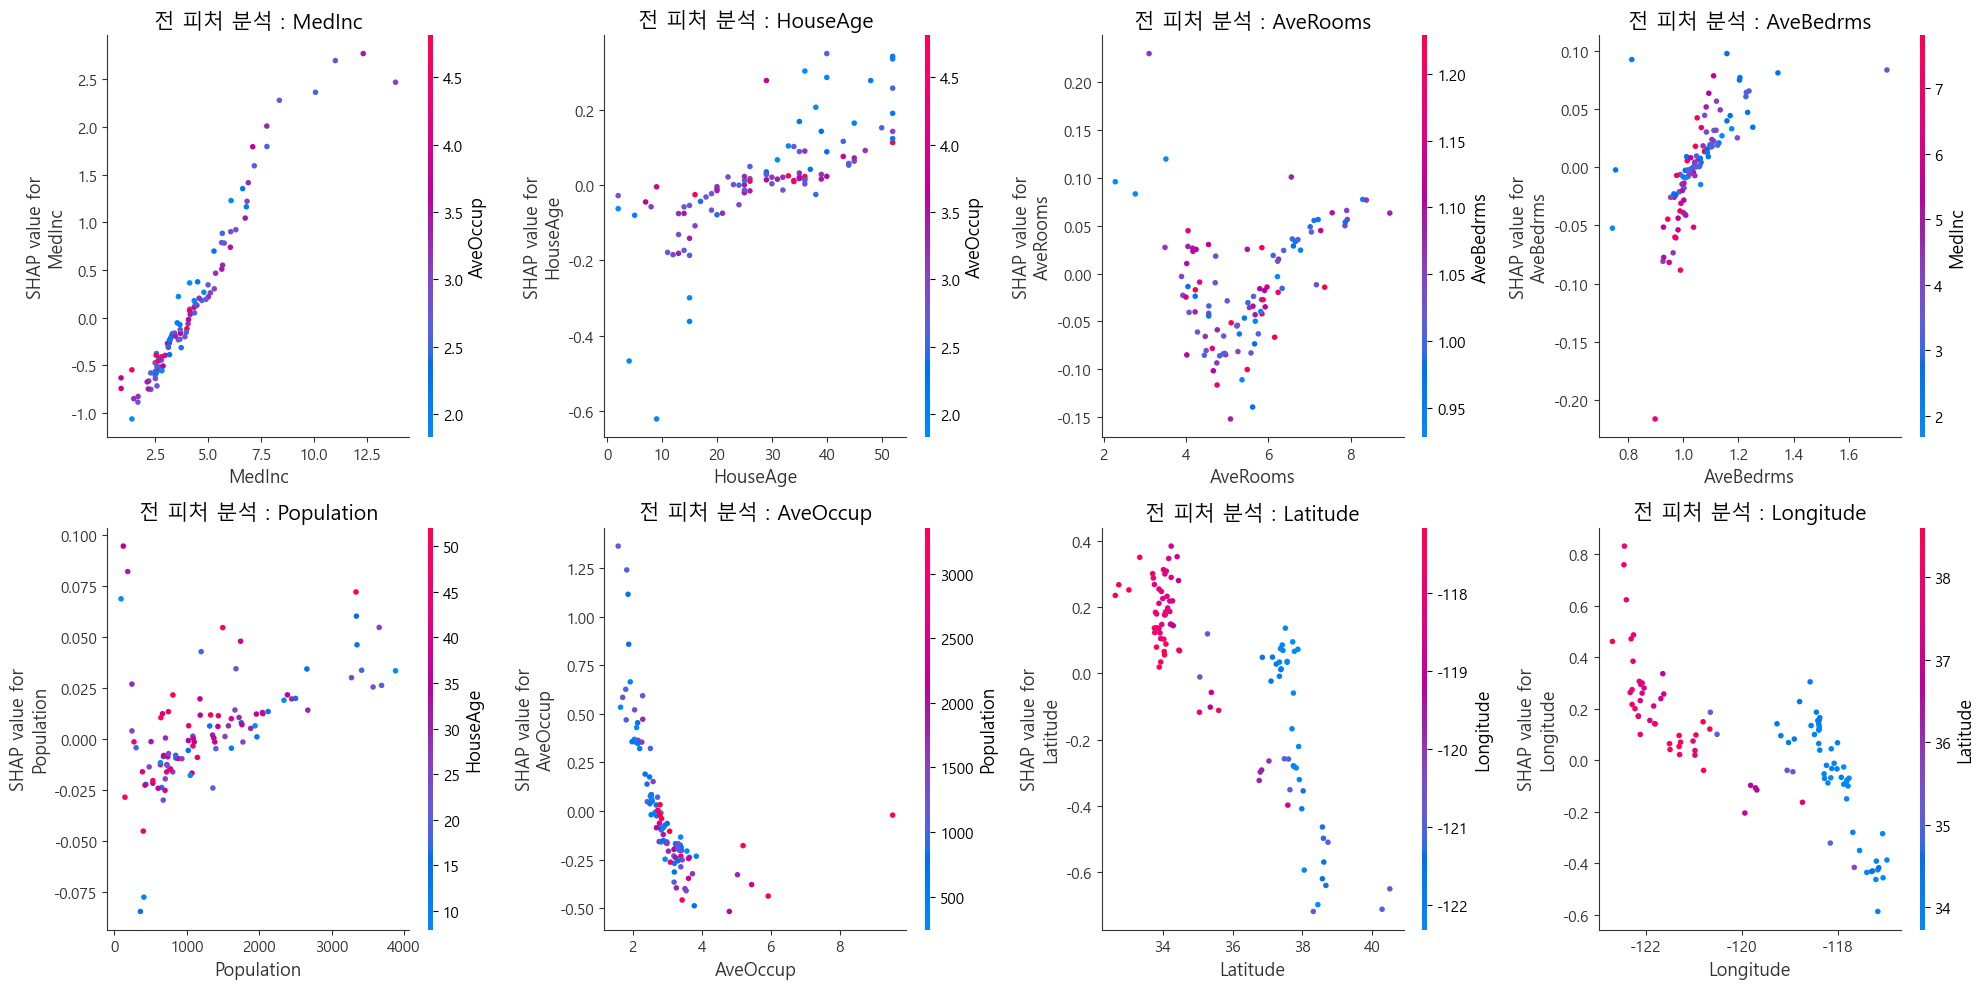

In [8]:
# 2-2 Dependence of Subplot
fig, axes = plt.subplots(2, 4, figsize = (20,10))
axes = axes.flatten()

for i, feature in enumerate(housing.feature_names):
    shap.dependence_plot(
        feature,
        explainer.shap_values(x_test_sample),
        x_test_sample,
        ax = axes[i],
        show = False
    )
    axes[i].set_title(f'전 피처 분석 : {feature}', fontsize = 15)
plt.tight_layout()
plt.show()

## 전체 피처 분석

| 구간 | 분석 결과(Observation) | 시사점 (Insight) | 제언 (Actionable Insight) |
| :--- | :--- | :--- | :--- |
| **위도/경도 (Latitude/Longitude)** | 특정 좌표에서 SHAP 값이 급등락함 |캘리포니아의 지리적 특성상 해안가와 내륙의 가격차가 있음|**지리적 특성이 소득만큼 강한 요인을 보임. 특정 지역 기반 타겟팅을 해야함**|
| **주택 연식 (HouseAge)** | 대체로 우상향이나 특정 구간 평탄함 |새 집일수록 가치가 높지만, 3~40년 넘은 주택도 관리가 잘된 부촌이라면 가격 방어가 됨|**연식 자체보다 리모델링 여부나 부촌 여부등 추가 데이터 확보 필요**|
| **방 개수 (AveRooms)** | 3 ~ 5구간 밀집, 그 이상은 기여도 유의미하지 않음 |일반적인 방 개수는 집값에 영향이 있으나, 너무 많은 방은 수요층이 적기에 기여도가 완만해짐|**실거주용 3 ~ 4인 가구 시장이 가장 활발하며 가격 변화가 민감하게 일어남**|
| **인구 수(Population)** | 수평에 가까운 일직선 |단순 인구수는 집값 결정에 있어 독립적이며 변별력이 거의 없음|**인구 수 보다는 인구 밀도나 유동인구 같은 것을 지표로 삼아야 질적으로 향상된 데이터 분석이 될 것임, 인구수는 분석에서 제외해도 될 것으로 판단**|


c:\DS-LOG\KIMDH\Lib\site-packages\shap\plots\_waterfall.py:279: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  text_bbox = txt_obj.get_window_extent(renderer=renderer)
c:\DS-LOG\KIMDH\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


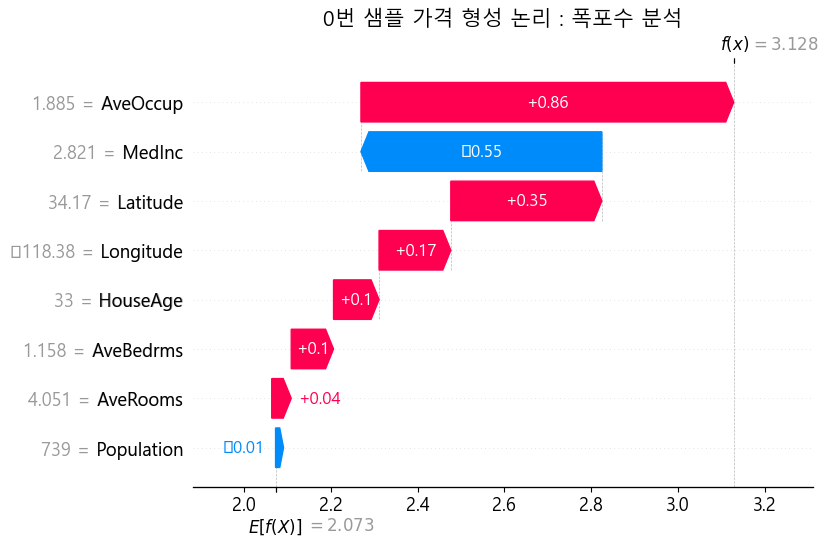

In [9]:
# 3. Waterfall Plot (폭포수 분석)
plt.figure(figsize = (12,8))
shap.plots.waterfall(explainer(x_test_sample)[0], show = False)
plt.title(f'0번 샘플 가격 형성 논리 : 폭포수 분석', fontsize = 15)
plt.show()

In [10]:
# 4. force plot 샘플 100개
shap_values_array = explainer.shap_values(x_test_sample)
import shap
shap.initjs()

shap.force_plot(
    explainer.expected_value, 
    shap_values_array, 
    x_test_sample
)

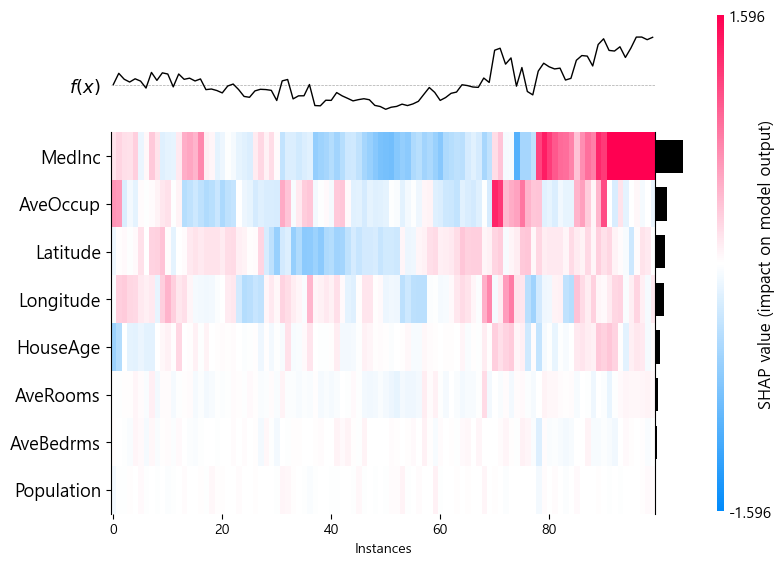

<Axes: xlabel='Instances'>

In [11]:
# 5. Heatmap
shap.plots.heatmap(explainer(x_test_sample))

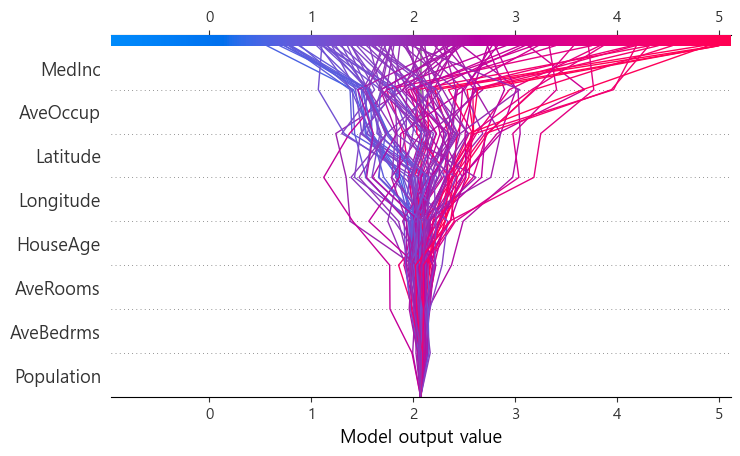

In [12]:
# 6. Decision plot
plt.figure(figsize=(10, 6))
shap.plots.decision(
    explainer.expected_value, 
    shap_values_array, 
    feature_names=list(housing.feature_names)
)
plt.show()

## SHAP 분석 실험 결론

본 실험은 캘리포니아 주택 가격(California Housing) 데이터를 기반으로 모델의 예측 논리를 심층 분석하였으며, 시각화 도구의 정밀 테스트를 통해 다음과 같은 결론을 도출함.

------------------------

### 1 .시각화 도구별 가치 평가
1. **Summary & Heatmap (전체 패턴 파악)**
   - **평가**: 데이터 전체의 흐름과 피처 간의 관계를 빠르게 스캔하여, 분석의 우선순위를 정하는데 가장 효과적임

2. **Dependence Plot (정밀 변수 분석)**
   - **평가**: 특정 피처의 변화가 예측값에 미치는 영향력을 곡선으로 파악하여, 비즈니스 전략을 세울 수 있는 '유의미한 구간'을 찾아냄

3. **Waterfall & Decision Plot (개별 사례)**
    - **평가**: 분석 결과를 비전문가에게 공유할 때, 예측 사유를 항목별 형태로 제시하여 보고의 신뢰도를 극대화함


------------------------

### 2. 워크플로우 제안

학습된 기술적 이해를 바탕으로, 분석 리소스를 최적화하고 인사이트의 깊이를 더하기 위해 다음과 같은 **4단계 전략적 파이프라인** 을 제안함

1. **데이터 스캔 (히트맵을 통한 노이즈 식별)**
    - **내용**: 전체 히트맵을 통해 시각적으로 기여도가 낮은 변수들을 1차 필터링
    - **목적**: 무의미한 정보에 분석 리소스를 낭비하지 않도록 초반 방향 설정
2. **모델 최적화 (함수를 활용한 유효 변수 선별)**
    - **내용**: 자체 개발한 Noise Scanner 함수로 수치적 근거를 확보하고 불필요한 피처 제거
    - **목적**: 모델의 복잡도를 낮추고 해석력을 높여, 더 정교한 인사이트 도출
3. **핵심 인사이트 도출 (변수별 유효 구간 정의)**
    - **내용**: 선별된 핵심 변수들을 디펜던스 플롯으로 분석하여 성과를 낼 수 있는 지점을 포착
    - **목적**: "그래서 무엇을 해야 하는가?"에 대한 구체적인 비즈니스 액션 플랜 수립
4. **신뢰성 검증 (특이 사례 분석 및 최종 리포트)**
    - **내용**: 이상치를 워터폴 플롯으로 분석하여 모델의 예외 상황까지 파악
    - **목적**: 예측의 근거를 명확시 제시하여 최종 의사결정권자의 동의를 끌어냄

------------------------
### 3. 헬퍼 함수 :  Noise_Scanner

- 위 워크플로우의 핵심인 **객관적 피처 선별**을 자동화하기 위해 설계된 함수입니다. 
- 분석가의 주관이 아닌 수학적 임계치를 기준으로 노이즈를 걸러내어 분석의 객관성을 보장합니다.


In [ ]:
import numpy as np
import pandas as pd

def Noise_Scanner(shap_obj, k=0.1): 
    """
    최고 기여도 대비 상대적 기여도 기반 노이즈 식별
    k: 최고 기여도 대비 컷오프 비율 (0.1 = 10%, 0.15 = 15%)
    """
    # 1. 기여도 체급 측정 (절대값 평균)
    # 임팩트 정의: 각 샘플에서 해당 변수가 예측값을 변화시킨 기여도의 평균
    importance_scores = np.abs(shap_obj.values).mean(axis=0)
    features = shap_obj.feature_names
    
    # 2. 최고 기여도 및 최고 기여도 피처 이름 추출
    ace_idx = np.argmax(importance_scores)
    ace_feature = features[ace_idx]
    ace_impact = importance_scores[ace_idx]
    
    # 3. 임계치 설정
    threshold = ace_impact * k
    
    # 4. 결과 정리
    report = pd.DataFrame({'Feature': features, 'Impact': importance_scores})
    report['Ratio_to_Ace'] = report['Impact'] / ace_impact
    report['Is_Noise'] = report['Impact'] <= threshold
    
    # 5. 보고서 작성
    print(f"====== [보고서] ======")
    print(f"현재 에이스: [{ace_feature}]")
    print(f"에이스 임팩트: {ace_impact:.4f}")
    print(f"노이즈 기준 : {threshold:.4f} (에이스 대비 {k*100}%)")
    print(f"---------------------------------------")
    
    if report['Is_Noise'].any():
        noise_list = report[report['Is_Noise']]['Feature'].tolist()
        print(f"노이즈 대상: {noise_list}")
        print(f"에이스인 '{ace_feature}'에 비해 기여도가 너무 낮아 필터링을 권장함.")
    else:
        print(f"모든 피처가 에이스의 {k*100}% 이상 기여합니다.")
        
    return report.sort_values(by='Impact', ascending=False)

In [95]:
report = Noise_Scanner(shap_obj)
display(report)

====== [보고서] ======
현재 에이스: [MedInc]
에이스 임팩트: 0.6192
노이즈 기준 : 0.0619 (에이스 대비 10.0%)
---------------------------------------
노이즈 대상: ['AveRooms', 'AveBedrms', 'Population']
에이스인 'MedInc'에 비해 기여도가 너무 낮아 필터링을 권장함.


,Feature,Impact,Ratio_to_Ace,Is_Noise
0,MedInc,0.619244,1.000000,False
5,AveOccup,0.264263,0.426751,False
6,Latitude,0.224567,0.362646,False
7,Longitude,0.201807,0.325893,False
1,HouseAge,0.096355,0.155601,False
2,AveRooms,0.051274,0.082801,True
3,AveBedrms,0.033071,0.053406,True
4,Population,0.019765,0.031917,True
